In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    precision_recall_curve,
    confusion_matrix,
    roc_curve,
    auc,
    mean_squared_error
)
import pickle


In [2]:
# Load dataset
df = pd.read_csv(r'D:\UCD\Spring\Data management and mining\Group Assignment\student_dataset.csv')

In [5]:
# Checking for missing values
print("\nChecking for Missing Values:")
print(df.isnull().sum())

# Checking the data types of each column
print("\nDataset Information:")
df.info()


Checking for Missing Values:
Transaction.Date      0
Transaction.Amount    0
Customer.Age          0
Account.Age.Days      0
Transaction.Hour      0
source                0
browser               0
Payment.Method        0
Product.Category      0
Quantity              0
Device.Used           0
Is.Fraudulent         0
dtype: int64

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Transaction.Date    240000 non-null  object 
 1   Transaction.Amount  240000 non-null  float64
 2   Customer.Age        240000 non-null  int64  
 3   Account.Age.Days    240000 non-null  int64  
 4   Transaction.Hour    240000 non-null  int64  
 5   source              240000 non-null  object 
 6   browser             240000 non-null  object 
 7   Payment.Method      240000 non-null  object 
 8   Product.Category    240000 non-

In [7]:
# Check class distribution before resampling
fraud_counts = df['Is.Fraudulent'].value_counts()
print("\nClass Distribution Before Resampling:")
print(fraud_counts)

# Define target variable and feature set
target_column = 'Is.Fraudulent'
df[target_column] = df[target_column].astype(int)
X = df.drop(columns=[target_column])
y = df[target_column]


Class Distribution Before Resampling:
Is.Fraudulent
0    222718
1     17282
Name: count, dtype: int64


In [9]:
# Ensure all features are numeric before applying SMOTE
X = X.select_dtypes(include=[np.number])  # Keep only numeric columns

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Scale the features
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)


In [3]:
def preprocess_no_feature_engineering(df_raw):
    """Preprocess the data without additional feature engineering."""
    df = df_raw.copy()

    # Check if 'Transaction.Date' exists in the dataset
    if "Transaction.Date" in df.columns:
        # Convert Transaction.Date to datetime
        df["Transaction.Date"] = pd.to_datetime(df["Transaction.Date"], errors="coerce")
        df["Transaction_Day"] = df["Transaction.Date"].dt.day.fillna(
            df["Transaction.Date"].dt.day.median()
        )
        df["Transaction_Month"] = df["Transaction.Date"].dt.month.fillna(
            df["Transaction.Date"].dt.month.median()
        )
        df["Transaction_Year"] = df["Transaction.Date"].dt.year.fillna(
            df["Transaction.Date"].dt.year.median()
        )
        df.drop(columns=["Transaction.Date"], inplace=True)
    else:
        print("Warning: 'Transaction.Date' column is missing from the dataset!")
        # Optionally add temporary columns if needed
        df["Transaction_Day"] = np.nan
        df["Transaction_Month"] = np.nan
        df["Transaction_Year"] = np.nan

    # Handle missing values in numeric columns
    numeric_columns = [
        "Transaction.Amount",
        "Customer.Age",
        "Account.Age.Days",
        "Transaction.Hour",
        "Quantity",
    ]
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

    # Encode Categorical Variables
    categorical_columns = [
        "source",
        "browser",
        "Payment.Method",
        "Product.Category",
        "Device.Used",
    ]
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = df[col].fillna(df[col].mode()[0])
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Convert Is.Fraudulent column to integer if it exists
    if "Is.Fraudulent" in df.columns:
        df["Is.Fraudulent"] = df["Is.Fraudulent"].astype(int)

    return df

In [4]:
# -------------------------------- Preprocessing With Feature Engineering --------------------------------

def preprocess_with_feature_engineering(df_raw):
    """Preprocess the data with advanced feature engineering."""
    df = preprocess_no_feature_engineering(df_raw)  # Start with basic preprocessing

    # Add Feature Engineering
    df["Transaction_per_AccountAge"] = df["Transaction.Amount"] / (df["Account.Age.Days"] + 1)
    df["Transaction_per_Quantity"] = df["Transaction.Amount"] / (df["Quantity"] + 1)
    df["Total_Spending"] = df["Transaction.Amount"] * df["Quantity"]

    # Spending Speed
    df["Spending_Speed"] = df["Total_Spending"] / (df["Account.Age.Days"] + 1)

    # High Amount Transaction Flag
    threshold = np.percentile(df["Transaction.Amount"], 75)
    df["High_Amount_Transaction"] = (df["Transaction.Amount"] > threshold).astype(int)

    return df


In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter Tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(50, 300, 50),         # [50, 100, 150, 200, 250]
    'max_depth': [None, 10, 20, 30, 40],           # Expanded depth options
    'min_samples_split': [2, 5, 10],               # Split options
    'min_samples_leaf': [1, 2, 4],                # Leaf options
    'max_features': ['sqrt', 'log2', None],       # Feature sampling options
    'bootstrap': [True, False]                    # Bootstrapping options
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='f1', n_jobs=-1, verbose=2, random_state=42
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [6]:
# -------------------------------- Model Training & Evaluation Function --------------------------------

def train_and_evaluate(X, y, description="Model"):
    """Train and evaluate a Random Forest classifier."""
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = rf_model.predict(X_test_scaled)
    y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

    # Evaluation Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Output
    print(f"\n--- {description} ---")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Not Fraud", "Fraud"],
        yticklabels=["Not Fraud", "Fraud"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {description}")
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {description}")
    plt.legend(loc="lower right")
    plt.show()



In [ ]:
# Train the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)


In [ ]:
# Evaluate the model
print("Best Hyperparameters:", random_search.best_params_)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Accuracy on Test Set: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")

In [ ]:
# Visualize Feature Importance
feature_importances = best_model.feature_importances_
features = X.columns
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance Plot")
plt.show()

In [ ]:
# Save the model
filename = 'model_1.pkl'
with open(filename, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Model saved as {filename}")

In [ ]:
# Create a comparison table
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Probability': y_pred_proba})
print(comparison_df.head())

# Model Selection and Performance Evaluation for Fraud Detection :


## Introduction 
In this project, we conducted a comprehensive evaluation of nine supervised learning models to identify the most suitable approach for fraud detection. The objective was to balance accuracy and F1 score to ensure reliable fraud classification. The dataset underwent extensive preprocessing and feature engineering before model implementation. The results of our evaluations are presented in the table below.

### Model Performance Overview
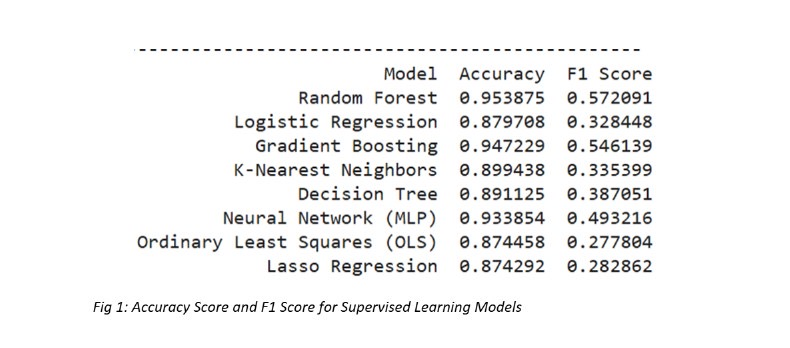

### Model Selection Process

We tested multiple models based on their ability to detect fraudulent transactions while maintaining computational efficiency. The primary criteria for selection included accuracy, F1 score, interpretability, and scalability. Below is an evaluation of the tested models and the rationale for their inclusion or exclusion.

#### Logistic Regression

- **Rationale for Testing**: A fundamental classification model that provides interpretability and serves as a baseline comparison.

- **Reason for Exclusion**: The model struggled to capture the complexities of fraud detection, resulting in a low F1 score of **0.328**.

#### Gradient Boosting

- **Rationale for Testing**: Known for its strong predictive performance and ability to handle imbalanced datasets.

- **Reason for Exclusion**: Although achieving a high accuracy of 94.72%, it required significant hyperparameter tuning and computational resources, making it less practical compared to Random Forest.

#### K-Nearest Neighbors (KNN)

- **Rationale for Testing**: A non-parametric approach that can capture complex decision boundaries.

- **Reason for Exclusion**: Computational inefficiency for large datasets and sensitivity to data scaling contributed to its lower F1 score of **0.335**.

#### Decision Tree

- **Rationale for Testing**: Provides explainability and fast training times.

- **Reason for Exclusion**: The model exhibited high variance, leading to overfitting and a suboptimal F1 score of **0.387**.

#### Neural Network (MLPClassifier)

- **Rationale for Testing**: Ability to learn complex patterns through deep learning techniques.

- **Reason for Exclusion**: While achieving an accuracy of 93.38%, it required extensive tuning and computational power without significant performance improvements over Random Forest.

#### Ordinary Least Squares (OLS) & Lasso Regression

- **Rationale for Testing**: Regression-based models were included to explore their effectiveness in binary classification.

- **Reason for Exclusion**: These models were not well-suited for classification tasks, as indicated by their low F1 scores of **0.278** and **0.283**, respectively.

### Final Model Selection: Random Forest Classifier 

After evaluating all models, Random Forest emerged as the most effective choice due to the following reasons:

- **Superior Performance**: It achieved the highest accuracy (95.39%) and F1 score (57.21%), ensuring a balanced approach to fraud detection.

- **Robustness to Overfitting**: Unlike Decision Trees, Random Forest mitigates overfitting by averaging multiple decision trees.

- **Handling of Imbalanced Data**: The ensemble nature of the model allows for better handling of skewed class distributions.

- **Computational Efficiency**: It provided a strong trade-off between predictive performance and computational cost, making it more practical than complex models like Gradient Boosting and Neural Networks.

- **Feature Importance Analysis**: Random Forest allows for interpretability by ranking feature importance, which is valuable for fraud analysis.

### Conclusion

Following extensive testing and evaluation, Random Forest was selected as the optimal model for fraud detection. It provided the best balance between accuracy, F1 score, and computational efficiency, making it the most practical and reliable choice for the given dataset. Future work may involve fine-tuning hyperparameters and incorporating additional ensemble techniques to further enhance performance.




